In [7]:
#Campeonato Quantamental
#Pegando dados P/L
import requests
import pandas as pd
import io
import json
import re
import pandas as pd
from pandas_datareader import data, wb
import numpy as np
from datetime import *

headers = {
    'authority': 'www.oceans14.com.br',
    'accept': 'application/json, text/javascript, */*; q=0.01',
    'user-agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Mobile Safari/537.36',
    'x-requested-with': 'XMLHttpRequest',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    # coloque aqui a url de qualquer canto que seja do site oceans14
    'referer': 'https://www.oceans14.com.br/acoes/itau-unibanco/itub/balanco-dividendos',
    'accept-language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7,la;q=0.6',
    'cookie': 'ASP.NET_SessionId=jypd15qvl1yu3ypbgqzecxjj; uid=0EAB27F50DB06E1775959795C4949E2D; origem=https://l.facebook.com/; contadorViewsAcoes=3',
}

params = (
    ######IDENTIFICAR TICKER DA ACAO######
    ('papel', 'ITUB3'),
    ('periodo', '10a'),
)

response = requests.get('https://www.oceans14.com.br/rendaVariavel/respostaAjax/gHistoricoPl.aspx', headers=headers, params=params)
dframe = pd.json_normalize(response.json())
jason = response.text
normal = json.loads(jason)
datas = []
valores = []
for row in normal["rows"]:
    date = row['c'][0]['v']
    formatedDate = re.search(r"(?<=Date\()[^\):]+(?=:?\))", date).group(0)
    simpleData = formatedDate.replace(',', '-').replace(' ', '')
    separatedData = simpleData.split('-')
    correctDataList = ''
    for number in separatedData:
        if number != '0':
            correctDataList += ("%02d" % int(number)) + "-"
    correctDataList = correctDataList[:-1]
    datas.append(correctDataList)
    valores.append(row['c'][1]['v'])
frameDict = {
    "Date": datas,
    "valores": valores
}
dframe = pd.DataFrame(data=frameDict)
dframe['valores'] = dframe['valores'].values.tolist()
dframe['valores'] = valores

In [8]:
#tickers = ['ITUB3.SA'] #IDENTIFICAR TICKER DA ACAO######
acao = 'ITUB3'
start_date = '2010-06-14'
end_date = '2020-06-08'
df = data.DataReader('ITUB3.SA', 'yahoo', start_date, end_date) #digitar ticker
df['Preco_Lucro'] = valores
tabela = df[['Close', 'Preco_Lucro']]

In [9]:
import talib
import matplotlib.pyplot as plt
import sys

upperband, middleband, lowerband = talib.BBANDS(tabela['Preco_Lucro'], timeperiod=200, nbdevup=3, nbdevdn=3, matype=0)
tabela['upperband'] = upperband
tabela['middleband'] = middleband
tabela['lowerband'] = lowerband
tabela

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,Close,Preco_Lucro,upperband,middleband,lowerband
Date,,,,,
2010-06-14,12.412600,11.00,NaN,NaN,NaN
2010-06-15,12.635700,10.72,NaN,NaN,NaN
2010-06-16,12.717700,10.87,NaN,NaN,NaN
2010-06-17,12.599300,10.99,NaN,NaN,NaN
2010-06-18,12.613000,11.01,NaN,NaN,NaN
...,...,...,...,...,...
2020-06-02,23.740000,10.68,15.268979,11.10695,6.944921
2020-06-03,24.500000,10.43,15.263161,11.10060,6.938039
2020-06-04,25.200001,10.59,15.259678,11.09635,6.933022


In [10]:
#Logico

def buy_sell(df): 
  compras = []
  vendas = []
  #tickers = 'AAPL' ######IDENTIFICAR TICKER DA ACAO######
  flag = 3
  #flag = 1 comprado
  #flag = 0 vendeu

  for i in range(len(df)):
    if tabela['Preco_Lucro'][i] < tabela['lowerband'][i]:   
      if flag != 1:
        compras.append(tabela['Close'][i])
        vendas.append(np.nan)
        flag = 1
      else:
        compras.append(np.nan)
        vendas.append(np.nan)

    elif (tabela['Preco_Lucro'][i] > tabela['upperband'][i]):
      if ((flag != 0) & (flag != 3)):
        compras.append(np.nan)
        vendas.append(tabela['Close'][i])
        flag = 0
      else:
        compras.append(np.nan)
        vendas.append(np.nan)

    else:
      compras.append(np.nan)
      vendas.append(np.nan)
        
  return (compras, vendas)

In [11]:
buy_sell = buy_sell(tabela)
tabela['compra'] = buy_sell[0] 
tabela['venda'] = buy_sell[1] 
tabela


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close,Preco_Lucro,upperband,middleband,lowerband,compra,venda
Date,,,,,,,
2010-06-14,12.412600,11.00,NaN,NaN,NaN,NaN,NaN
2010-06-15,12.635700,10.72,NaN,NaN,NaN,NaN,NaN
2010-06-16,12.717700,10.87,NaN,NaN,NaN,NaN,NaN
2010-06-17,12.599300,10.99,NaN,NaN,NaN,NaN,NaN
2010-06-18,12.613000,11.01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-06-02,23.740000,10.68,15.268979,11.10695,6.944921,NaN,NaN
2020-06-03,24.500000,10.43,15.263161,11.10060,6.938039,NaN,NaN
2020-06-04,25.200001,10.59,15.259678,11.09635,6.933022,NaN,NaN


KeyError: 'compra'

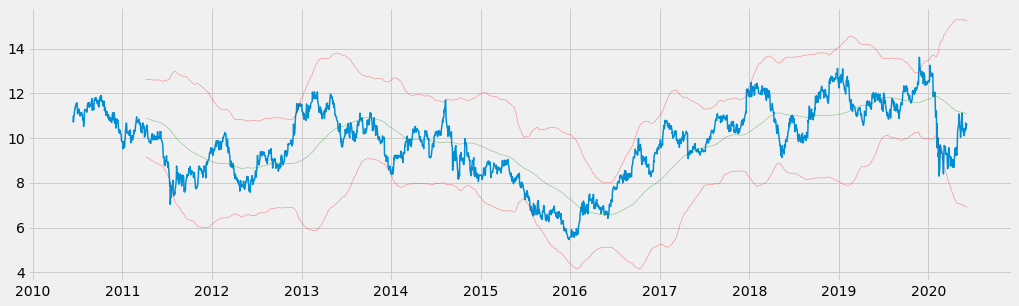

In [12]:
#tickers = 'AAPL' ######IDENTIFICAR TICKER DA ACAO######
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15.7,4.7))
plt.plot(tabela['Preco_Lucro'], label = 'Preço/Lucro', alpha = 1, linewidth=1.5)
plt.plot(tabela['middleband'], label = 'Media',alpha = 0.5, linewidth=0.5, color='green')
plt.plot(tabela['upperband'], label = 'Banda Superior',alpha = 0.5, linewidth=0.5, color='red')
plt.plot(tabela['lowerband'], label = 'Banda Inferior',alpha = 0.5, linewidth=0.5, color='red')
plt.scatter(df.index, df['compra'], label = 'Buy', marker='^',color = 'green', s=100)
plt.scatter(df.index, df['venda'], label = 'Sell',marker="v",color = 'red', s=100)
plt.xlabel('14/06/2010 à 09/06/2020', fontsize =15)
plt.title(acao, fontsize=20)
plt.legend(loc='best')

In [9]:
#Calculo retorno da estrategia
#tabela['retorno']=tabela['Close'].pct_change()
#retorno = tabela['retorno'].sum()

def retorno(retorno):
    buy = []
    sell = []

    for i in range(df['compra'][i]):
        if tabela['compra'][i] >= 1: 
            buy.append(tabela['Close'][i])
        else:
            None
        if tabela['venda'][i] >= 1:   
            sell.append(tabela['Close'][i])
        else:
            None
            
    return (buy, sell)


<function __main__.retorno(retorno)>